In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time

# Activations Functions

Between dense layers, we place an **activation function** to transform the features elementwise. They are also known as **nonlinearities** as the purpose of an activation function is to break the linear relationship defined by the dense layers.

## Squashing Activations: Sigmoid, Tanh

The first activation functions were proposed from a biologically inspired perspective, and aimed to model the 'spiking' behavior of biological neurons. The **sigmoid** function squashes inputs to a range between `(0,1)`, and **tanh (hyperbolic tangent)** squashes between `(1,1)`. Squashing activations are good for ensuring numerical stability, since we know the magnitude of the outputs will always be constrained. However, when the inputs are too large in magnitude, the gradient of a squashing function will approach zero. This creates the **vanishing gradient problem** where a neural network will have a hard time improving when features become too large. 

In [16]:
def plot_activations(fn_list, fn_names):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    x = jnp.linspace(-5, 5, 100)
    for i in range(len(fn_list)):
        axs[0].plot(x, fn_list[i](x), label=fn_names[i])
        axs[1].plot(x, jax.vmap(jax.grad(fn_list[i]))(x), label=fn_names[i])
    axs[0].axhline(0, color='black', linewidth=0.5)
    axs[0].axhline(0, color='black', linewidth=0.5)
    axs[0].title.set_text('Activation')
    axs[0].legend()
    axs[1].axhline(0, color='black', linewidth=0.5)
    axs[1].title.set_text('Derivative')
    axs[1].legend()
    plt.show()

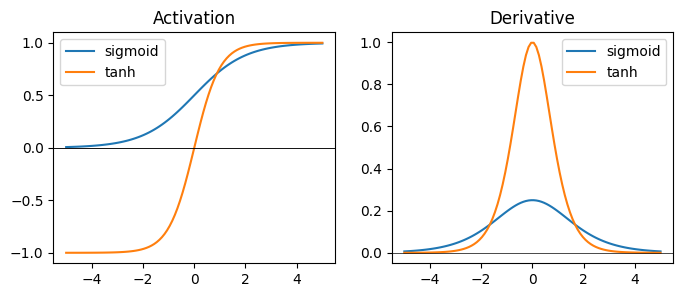

In [17]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))
def tanh(x):
    return (jnp.exp(x) - jnp.exp(-x)) / (jnp.exp(x) + jnp.exp(-x))

plot_activations([sigmoid, tanh], ['sigmoid', 'tanh'])

## Unbounded Activations: ReLU, ELU, GELU, Swish, Mish

In an effort to combat the vanishing gradient problem, the next class of activations instead model a piecewise nonlinearity. The simplest of these is the **rectified linear unit (ReLU)** which simply takes the form:

$$
relu(x) = max(0, x).
$$

The ReLU lets positive values through without change, and clips negative values to zero. While this ensures a well-behaved gradient at all points, the gradient at negative values is zero, which potentially slows down learning. The **leaky ReLU** uses a constant multiplier on the negative portion rather than a hard clip.

$$
\text{leaky\_relu}(x) = \begin{cases}
0.2x & \text{if} \quad x \leq 0 \\
x & \text{if} \quad > 0\\
\end{cases}
$$

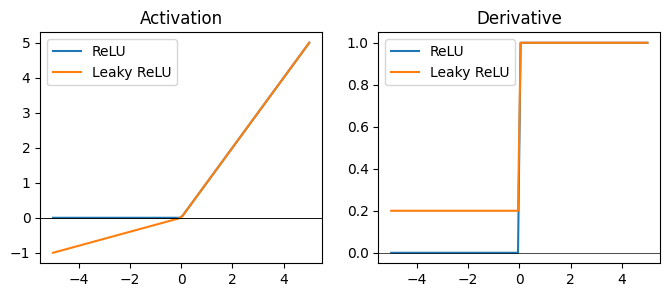

In [19]:
def relu(x):
    return jnp.maximum(0, x)
def leaky_relu(x):
    return jnp.maximum(0.2 * x, x)

plot_activations([relu, leaky_relu], ['ReLU', 'Leaky ReLU'])

The ReLU family is highly effective, and in most models today use some variants of the ReLU activation. More modern activation functions attempt to address certain theoretical problems with the naive ReLU. **Exponential linear unit (ELU)** uses a saturating function that is lower bounded to `(-1, inf)`. 

Several activation functions introduce a non-monoticity property, such that the activation has a small dip near zero. This is argued to increase expressivity and gradient flow. Examples of such functions are the **Gaussian error linear unit (GELU)**, **Swish**, and **Mish**. Swish and Mish are referred to as **self-gating** activation functions, as they take the form `f(x) = x * gate(x)`, where `gate(x)` is a squashed function.

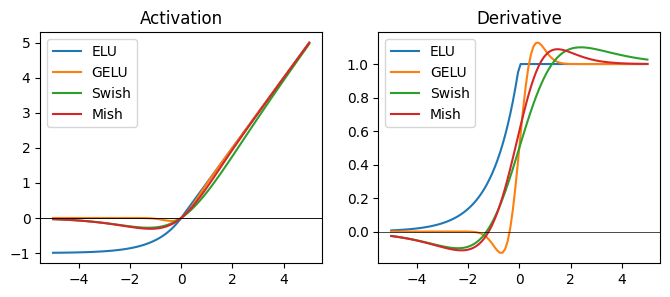

In [20]:
def elu(x):
    return jnp.where(x > 0, x, jnp.exp(x) - 1)
def gelu(x):
    return 0.5 * x * jax.lax.erfc(-x / jnp.sqrt(0.5))
def swish(x):
    return x * sigmoid(x)
def mish(x):
    return x * jnp.tanh(jnp.log(1 + jnp.exp(x)))
plot_activations([elu, gelu, swish, mish], ['ELU', 'GELU', 'Swish', 'Mish'])

***

# Normalization Functions

Under normal assumptions, we have no guarantees that the features at each layer are well-behaved. For numerical reasons, we often would like all our features to be normalized in some way, to maintain a mean of zero and unit variance. To achieve this property, we often insert **normalization functions** at key stages within the neural network.

![n](norms.png)
> Source: [Wu and He, 2018](https://arxiv.org/abs/1803.08494). Various normalization schemes.

## Batch Norm

The first proposed technique was **batch norm**, which attempts to normalize the expectation of a given feature under the entire batch. To do this, we can simply calculate the mean and standard deviation of each feature elementwise, then divide the features by these statistics when passing through the batch norm layer. The downside of batch norm is the dependency on a large enough batch -- at small batch sizes, the calculated mean/variances may be inaccurate. Also, we need to know what to do at inference time -- typically, we would keep a running average of the mean/stddev of each feature during training, then normalize by these values during test time.

**Why can't we use the running average during training**? An astute reader will ask why we can't use our high-accuracy averages during training. The catch is we need to **backprop through the normalization**. Let's assume that the gradient of a particular feature points towards increasing its value. If the normalization statistics are treated as a constant, then this gradient will be unchanged. However, if the statistics are themselves included in the gradient update, then gradient update will take the normalization into account and avoid naively increasing the feature value.

```{image} projection.png
:width: 200px
:align: center
```
<br>

> Source: [Sutti and Yueh 2024](https://arxiv.org/abs/2403.11726v1). When normalization is included in gradient calculation, the gradient will be tangent on the constraint surface (sphere).

In [38]:
x = np.random.randn(1000, 100) * 10 # Batch of 1000, with 100 features each.
x += np.arange(100) # Add some per-feature correlations.
print('(Un-normalized) Average std per feature:', jnp.mean(jnp.std(x, axis=0)))
print('(Un-normalized) Average std of feature vector:', jnp.mean(jnp.std(x, axis=1)))

def batch_norm(x):
    mean = jnp.mean(x, axis=0)[None, :]
    var = jnp.var(x, axis=0)[None, :]
    return (x - mean) / jnp.sqrt(var + 1e-5)
y = batch_norm(x)
print('Average std per feature:', jnp.mean(jnp.std(y, axis=0)))
print('Average std of feature vector:', jnp.mean(jnp.std(y, axis=1)))

(Un-normalized) Average std per feature: 10.009361
(Un-normalized) Average std of feature vector: 30.478842
Average std per feature: 1.0
Average std of feature vector: 0.99203044


## Layer Norm

Motivated by a desire to remove the batch-dependent scaling, **layer norm** picks a different axis of normalization. Now, instead of normalizing across the batch dimension, we instead normalize across the feature dimension. This technique means that while each individual feature may not have unit variance, the total scale/variance of a feature *vector* will be normalized.

In [39]:
x = np.random.randn(1000, 100) * 10 # Batch of 1000, with 100 features each.
x += np.arange(100) # Add some per-feature correlations.
def layer_norm(x):
    mean = jnp.mean(x, axis=1)[..., None]
    var = jnp.var(x, axis=1)[..., None]
    return (x - mean) / jnp.sqrt(var + 1e-5)
y = layer_norm(x)
print('Average std per feature:', jnp.mean(jnp.std(y, axis=0)))
print('Average std of feature vector:', jnp.mean(jnp.std(y, axis=1)))

Average std per feature: 0.32418188
Average std of feature vector: 1.0


## Instance Norm

**Instance norm** is only relevant in convolutional networks, which have an additional `(height * width)` dimension in their features. Transformers today also have an additional `(sequence length)` dimension, so in principle one can use instance norm there. Let's call this the **parallel dimension**, and consider feature tensors of the form `(batch, parallel, num_features)`. The idea here is to normalize individual feature statistics, but within the `parallel` dimension rather than the `batch` dimension. This way we can be batch-agnostic, but still properly normalize.

In [44]:
x = np.random.randn(1000, 200, 100) * 10 # Batch of 1000, with 200 parallel, with 100 features each.
x += np.arange(100)[None, None, :] # Add some per-feature correlations.
x += np.arange(200)[None, :, None] # Add some per-parallel correlations.
def instance_norm(x):
    mean = jnp.mean(x, axis=1)[:, None, :]
    var = jnp.var(x, axis=1)[:, None, :]
    return (x - mean) / jnp.sqrt(var + 1e-5)
y = instance_norm(x)
print('Average std per feature:', jnp.mean(jnp.std(y, axis=(0,1,2))))
print('Average std of feature vector:', jnp.mean(jnp.std(y, axis=(0,1))))
print('Average std within parallel axis:', jnp.mean(jnp.std(y, axis=(0,2))))

Average std per feature: 0.99999976
Average std of feature vector: 1.0
Average std within parallel axis: 0.16981931


## Group Norm

In between instance norm and layer norm is **group norm**. The idea here is to normalize all features within the parallel axis (same as instance norm), but *also* within an N-sized group along the feature dimension. Group norm allows for there to be additional normalization dependencies between certain feature groups.

In [48]:
x = np.random.randn(1000, 200, 100) * 10 # Batch of 1000, with 200 parallel, with 100 features each.
x += np.arange(100)[None, None, :] # Add some per-feature correlations.
x += np.arange(200)[None, :, None] # Add some per-parallel correlations.
def group_norm(x):
    mean = jnp.mean(x, axis=1)[:, None, :]
    var = jnp.var(x, axis=1)[:, None, :]
    x = (x - mean) / jnp.sqrt(var + 1e-5)
    num_groups = 10
    xg = x.reshape(x.shape[0], x.shape[1], num_groups, -1)
    group_means = jnp.mean(xg, axis=2, keepdims=True)
    group_vars = jnp.var(xg, axis=2, keepdims=True)
    return ((xg - group_means) / jnp.sqrt(group_vars + 1e-5)).reshape(x.shape)
y = group_norm(x)
print('Average std per feature:', jnp.mean(jnp.std(y, axis=(0,1,2))))
print('Average std of feature vector:', jnp.mean(jnp.std(y, axis=(0,1))))
print('Average std within parallel axis:', jnp.mean(jnp.std(y, axis=(0,2))))

Average std per feature: 0.999752
Average std of feature vector: 0.99975175
Average std within parallel axis: 0.9997527


## Weight Norm

Another approach is to use **weight norm**, which does not operate on features but instead the raw parameter matrices. Here, we need to assume that the inputs to the dense layer are already normalized -- we just want to make sure that they *remain* normalized as outputs. We can do this by normalizing the dense parameter matrix across the feature dimension. Each *feature* is therefore an RMSNorm-1 function of its inputs.

In [3]:
x = np.random.randn(1000, 100) * 10 # Batch of 1000, with 100 features each.
x += np.arange(100) # Add some per-feature correlations.
x = (x - jnp.mean(x, axis=0)) / jnp.std(x, axis=0) # Normalize.

W = np.random.randn(100, 50) / np.sqrt(100)
W += np.arange(50)[None, :] # Add some per-feature correlations.
y = x @ W
print('(Un-normalized) Average std per feature:', jnp.mean(jnp.std(y, axis=0)))
print('(Un-normalized) Average std of feature vector:', jnp.mean(jnp.std(y, axis=1)))

def weight_norm(w):
    return w / jnp.linalg.norm(w, axis=0, keepdims=True)
Wp = weight_norm(W)
yp = x @ Wp
print('Average std per feature:', jnp.mean(jnp.std(yp, axis=0)))
print('Average std of feature vector:', jnp.mean(jnp.std(yp, axis=1)))

(Un-normalized) Average std per feature: 241.60356
(Un-normalized) Average std of feature vector: 112.21661
Average std per feature: 0.9859988
Average std of feature vector: 0.16107996


**Is weight norm the same as any of the previous normalization layers?** No. The simple example is if an input to the dense layer has a magnitude of 1000. Activation-based norms will handle this properly, and scale down the resulting outputs. But weight norm will preserve the norm of the input vector.

**Does weight norm always preserve the norm of the input vector?** Again, no. Weight norm will preserve the norm of the input in expectation, assuming each coordinate of the input is independent. However, if the input vector happens to correctly **align** with the parameter matrix, then the norm of the output can increase. Here is an example:

In [62]:
def rms_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis))

print('Independent inputs and parameters.')
x = np.random.randn(1000, 100) / np.sqrt(100)
W = np.random.randn(100, 100)
Wp = weight_norm(W)
yp = x @ Wp
print('Average RMSNorm of input vector:', jnp.mean(rms_norm(x, axis=1)))
print('Average RMSNorm of output vector:', jnp.mean(rms_norm(yp, axis=1)))

print('*Aligned* inputs and parameters.')
x = np.zeros((1000, 100))
x[:, 0] = 1 ,
W = np.zeros((100, 100))
W[0, :] = 1
Wp = weight_norm(W)
yp = x @ Wp
print('Average RMSNorm of input vector:', jnp.mean(rms_norm(x, axis=1)))
print('Average RMSNorm of output vector:', jnp.mean(rms_norm(yp, axis=1)))

Independent inputs and parameters.
Average RMSNorm of input vector: 0.9961614
Average RMSNorm of output vector: 0.9954167
*Aligned* inputs and parameters.
Average RMSNorm of input vector: 1.0
Average RMSNorm of output vector: 10.0


For independent inputs, the RMS norm is preserved via weight normalization. For aligned inputs, the RMS norm of the output increases to 10. This example shows an inherent tension in activation-unaware normalization -- **The product of norm-1 inputs and norm-1 weights is a norm-1 output if they are independent. In the worst case, the output can have a norm of `sqrt(n)`.**

This behavior is actually an example of why picking the correct matrix norms is important. The **Frobenius norm** of a matrix is equivalent to its RMS norm (if seen as a vector), and is the square root of the sum of squared singular values. When we perform weight normalization on a matrix, we set its Frobenius norm to 1. However, the **spectral norm** of a matrix is its *maximum* singular value. In the worst case, a matrix with Frobenius norm of 1 can have a spectral norm of `sqrt(n)`, which is realized when the input vector perflect aligns with this largest singular vector.

## 